In [1]:
#| echo: false

# import image module
from IPython.display import Image

# get the image
Image(url="./Datasets/Regularization.webp",width=700, height=300)

In [2]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('ggplot')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 5, 4

## Why do we need regularization? 

###  The Challenge of Overfitting and Underfitting
When building machine learning models, we aim to find patterns in data that generalize well to unseen samples. However, models can suffer from two key issues:

- **Underfitting**: The model is too simple to capture the underlying pattern in the data.
- **Overfitting**: The model is too complex and captures noise rather than generalizable patterns.

**Regularization** is a technique used to address overfitting by penalizing overly complex models.

### Understanding the Bias-Variance Tradeoff
A well-performing model balances two competing sources of error:

- **Bias**: Error due to overly simplistic assumptions (e.g., underfitting).
- **Variance**: Error due to excessive sensitivity to training data (e.g., overfitting).

A **high-bias** model (e.g., a simple linear regression) may not capture the underlying trend, while a **high-variance** model (e.g., a deep neural network with many parameters) may memorize noise instead of learning meaningful patterns.

Regularization helps **reduce variance** while maintaining an appropriate level of model complexity.

### Visualizing Overfitting vs. Underfitting
To better understand this concept, consider three different models:

1. **Underfitting (High Bias)**: The model is too simple and fails to capture important trends.
2. **Good Fit (Balanced Bias & Variance)**: The model generalizes well to unseen data.
3. **Overfitting (High Variance)**: The model is too complex and captures noise, leading to poor generalization.

$$
\text{Total Error} = \text{Bias}^2 + \text{Variance} + \text{Irreducible Error}
$$

Regularization helps control **variance** by penalizing large coefficients, leading to a model that generalizes better.





## Simulating Data for an Overfitting Linear Model

### Generating the data

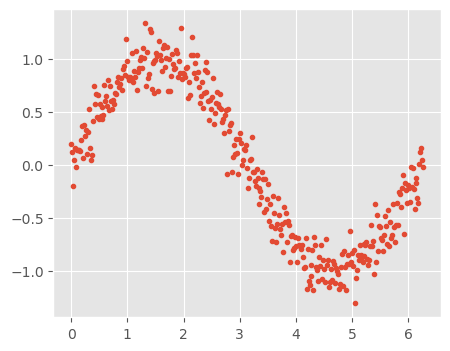

In [3]:
#Define input array with angles from 60deg to 300deg converted to radians
x = np.array([i*np.pi/180 for i in range(360)])
np.random.seed(10)  #Setting seed for reproducibility
y = np.sin(x) + np.random.normal(0,0.15,len(x))
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(data['x'],data['y'],'.');

In [4]:
# check how the data looks like
data.head()

,x,y
0,0.000000,0.199738
1,0.017453,0.124744
2,0.034907,-0.196911
3,0.052360,0.051078
4,0.069813,0.162957


Polynomial features allow linear regression to model non-linear relationships. Higher-degree terms capture more complex patterns in the data.
Let's manually expands features, similar to `PolynomialFeatures` in `sklearn.preprocessing`.
Using polynomial regression, we can evaluate different polynomial degrees and analyze the balance between underfitting and overfitting.

In [5]:
for i in range(2,16):  #power of 1 is already there
    colname = 'x_%d'%i      #new var will be x_power
    data[colname] = data['x']**i
data.head()

,x,y,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15
0,0.000000,0.199738,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.017453,0.124744,0.000305,0.000005,9.279177e-08,1.619522e-09,2.826599e-11,4.933346e-13,8.610313e-15,1.502783e-16,2.622851e-18,4.577739e-20,7.989662e-22,1.394459e-23,2.433790e-25,4.247765e-27
2,0.034907,-0.196911,0.001218,0.000043,1.484668e-06,5.182470e-08,1.809023e-09,6.314683e-11,2.204240e-12,7.694250e-14,2.685800e-15,9.375210e-17,3.272566e-18,1.142341e-19,3.987522e-21,1.391908e-22
3,0.052360,0.051078,0.002742,0.000144,7.516134e-06,3.935438e-07,2.060591e-08,1.078923e-09,5.649226e-11,2.957928e-12,1.548767e-13,8.109328e-15,4.246034e-16,2.223218e-17,1.164074e-18,6.095079e-20
4,0.069813,0.162957,0.004874,0.000340,2.375469e-05,1.658390e-06,1.157775e-07,8.082794e-09,5.642855e-10,3.939456e-11,2.750259e-12,1.920043e-13,1.340443e-14,9.358057e-16,6.533156e-17,4.561003e-18


What This Code Does

- **Generates Higher-Degree Polynomial Features**: Iterates over the range **2 to 15**, computing polynomial terms (`x², x³, ..., x¹⁵`).
- **Dynamically Creates Column Names**: New feature names are automatically generated in the format **`x_2, x_3, ..., x_15`**.
- **Expands the Dataset**: Each polynomial-transformed feature is stored 


### Splitting the Data

Next, we will split the data into **training and testing sets**. As we’ve learned, models tend to **overfit** when trained on a small dataset.  

To intentionally create an **overfitting scenario**, we will:
- Use **only 10% of the data for training**.
- Reserve **90% of the data for testing**.

This is **not a typical train-test split** but is deliberately done to **demonstrate overfitting**, where the model performs well on the training data but generalizes poorly to unseen data.


In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.9)

In [7]:
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 36
Number of observations in the test data: 324


### Splitting the target and features

In [8]:
X_train = train.drop('y', axis=1).values
y_train = train.y.values
X_test = test.drop('y', axis=1).values
y_test = test.y.values

### Building Models

#### Building a linear model with only 1 predictor `x`

Training Error 0.22398220582126424
Testing Error 0.22151086120574928


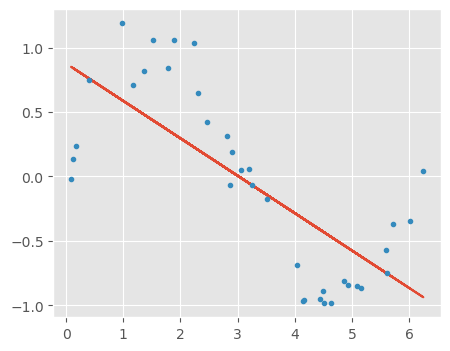

In [9]:
# Linear regression with one feature
independent_variable_train = X_train[:, 0:1]

linreg = LinearRegression()
linreg.fit(independent_variable_train, y_train)
y_train_pred = linreg.predict(independent_variable_train)
rss_train = sum((y_train_pred-y_train)**2)/X_train.shape[0]

independent_variable_test = X_test[:, 0:1]
y_test_pred = linreg.predict(independent_variable_test)
rss_test = sum((y_test_pred-y_test)**2)/X_test.shape[0]

print("Training Error", rss_train)
print("Testing Error", rss_test)

plt.plot(X_train[:, 0:1], y_train_pred)
plt.plot(X_train[:, 0:1], y_train, '.');

#### Building a linear regression model with three features `x, x_2, x_3`


In [10]:
independent_variable_train = X_train[:, 0:3]
independent_variable_train[:3]

array([[ 1.36135682,  1.85329238,  2.52299222],
       [ 2.30383461,  5.30765392, 12.22795682],
       [ 1.51843645,  2.30564925,  3.50098186]])

In [11]:
def sort_xy(x,y):
    idx = np.argsort(x)
    x2,y2= x[idx] ,y[idx] 
    return x2,y2

Training Error 0.02167114498970705
Testing Error 0.028159311299747036


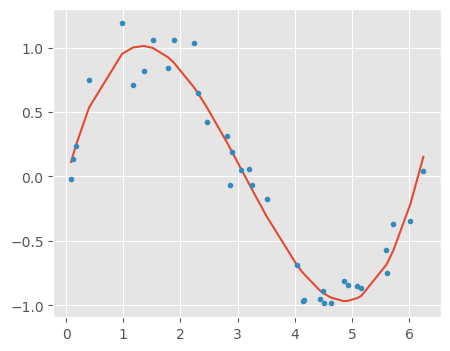

In [12]:
# Linear regression with 3 features

linreg = LinearRegression()

linreg.fit(independent_variable_train, y_train)
y_train_pred = linreg.predict(independent_variable_train)
rss_train = sum((y_train_pred-y_train)**2)/X_train.shape[0]

independent_variable_test = X_test[:, 0:3]
y_test_pred = linreg.predict(independent_variable_test)
rss_test = sum((y_test_pred-y_test)**2)/X_test.shape[0]

print("Training Error", rss_train)
print("Testing Error", rss_test)

plt.plot(*sort_xy(X_train[:, 0], y_train_pred))
plt.plot(X_train[:, 0], y_train, '.');

Let's define a helper function that dynamically builds and trains a linear regression model based on a specified number of features. It allows for flexibility in selecting features and automates the process for multiple models.

In [13]:
# Define a function which will fit linear vregression model, plot the results, and return the coefficient
def linear_regression(train_x, train_y, test_x, test_y, features, models_to_plot):
    
    #fit the model
    linreg = LinearRegression()
    linreg.fit(train_x, train_y)
    train_y_pred = linreg.predict(train_x)
    test_y_pred = linreg.predict(test_x)
    
    #check if a plot is to be made for the entered features
    if features in models_to_plot:
        plt.subplot(models_to_plot[features])
        # plt_tight_layout()
        plt.plot(*sort_xy(train_x[:, 0], train_y_pred))
        plt.plot(train_x[:, 0], train_y, '.')
        
        plt.title('Number of Predictors: %d'%features)
        
    #return the result in pre-defined format
    rss_train = sum((train_y_pred - train_y)**2)/train_x.shape[0]
    ret = [rss_train]
    
    rss_test = sum((test_y_pred - test_y)**2)/test_x.shape[0]
    ret.extend([rss_test])
    
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    
    return ret

In [14]:
#initialize a dataframe to store the results:
col = ['mrss_train', 'mrss_test', 'intercept'] + ['coef_VaR_%d'%i for i in range(1, 16)]
ind = ['Number_of_variable_%d'%i for i in range(1, 16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

In [15]:
# Define the number of features for which a plot is required:
models_to_plot = {1:231, 3:232, 6:233, 9:234, 12:235, 15:236}

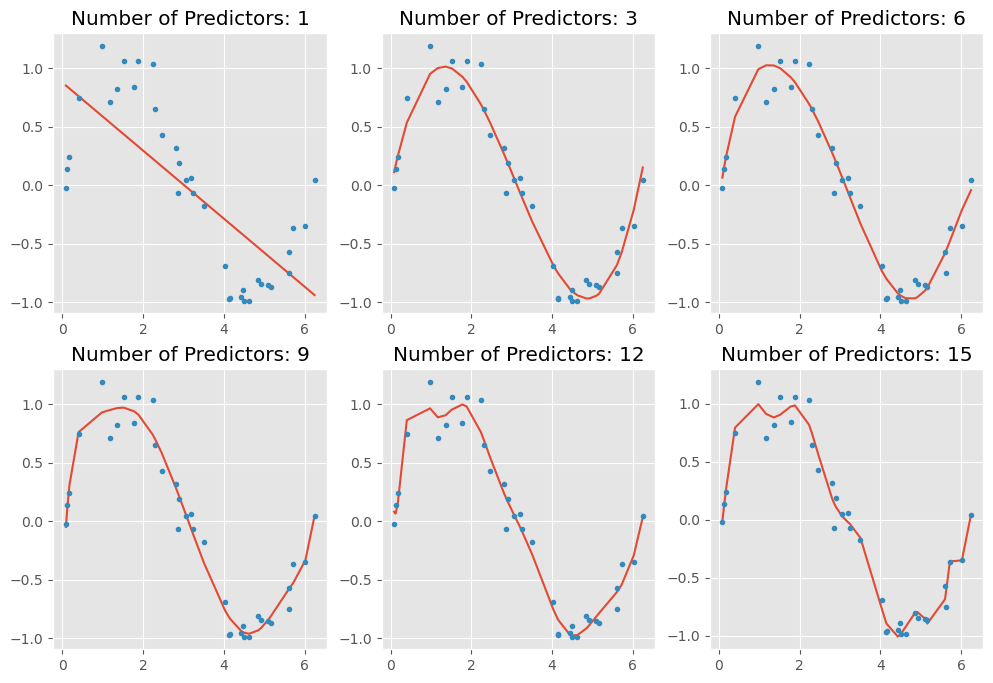

In [16]:
import matplotlib.pyplot as plt
# Iterate through all powers and store the results in a matrix form
plt.figure(figsize = (12, 8))
for i in range(1, 16):
    train_x = X_train[:, 0:i]
    train_y = y_train
    test_x = X_test[:, 0:i]
    test_y = y_test
    
    coef_matrix_simple.iloc[i-1, 0:i+3] = linear_regression(train_x, train_y, test_x, test_y, features=i, models_to_plot=models_to_plot)

**Key Takeaways:**

As we increase the number of features (higher-degree polynomial terms), we observe the following:  
- The model becomes **more flexible**, capturing intricate patterns in the training data.  
- The curve becomes **increasingly wavy and complex**, adapting too closely to the data points.  
- This results in **overfitting**, where the model performs well on the training set but fails to generalize to unseen data.  

Overfitting occurs because the model learns **noise** instead of the true underlying pattern, leading to poor performance on new data.



To better understand this phenomenon, let's:  
- **Evaluate model performance** on both the training and test sets.  
- **Output the model coefficients** to analyze how feature coefficients  changes with increasing complexity.  

In [17]:
# Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

,mrss_train,mrss_test,intercept,coef_VaR_1,coef_VaR_2,coef_VaR_3,coef_VaR_4,coef_VaR_5,coef_VaR_6,coef_VaR_7,coef_VaR_8,coef_VaR_9,coef_VaR_10,coef_VaR_11,coef_VaR_12,coef_VaR_13,coef_VaR_14,coef_VaR_15
Number_of_variable_1,0.22,0.22,0.88,-0.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Number_of_variable_2,0.22,0.22,0.84,-0.25,-0.0057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Number_of_variable_3,0.022,0.028,-0.032,1.7,-0.83,0.089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Number_of_variable_4,0.021,0.03,-0.09,2,-1,0.14,-0.0037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Number_of_variable_5,0.02,0.025,-0.019,1.5,-0.48,-0.092,0.037,-0.0026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Number_of_variable_6,0.019,0.029,-0.13,2.4,-1.9,0.77,-0.21,0.031,-0.0017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Number_of_variable_7,0.017,0.034,-0.37,4.7,-6.5,4.7,-1.9,0.4,-0.044,0.0019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Number_of_variable_8,0.017,0.035,-0.42,5.3,-8,6.4,-2.9,0.73,-0.1,0.0076,-0.00022,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Number_of_variable_9,0.016,0.036,-0.57,7.1,-14,16,-9.9,3.8,-0.91,0.13,-0.011,0.00037,NaN,NaN,NaN,NaN,NaN,NaN
Number_of_variable_10,0.016,0.036,-0.51,6.2,-11,9.7,-4.5,0.83,0.11,-0.087,0.018,-0.0017,6.6e-05,NaN,NaN,NaN,NaN,NaN


Let's plot the training error versus the test error below and identify the overfitting

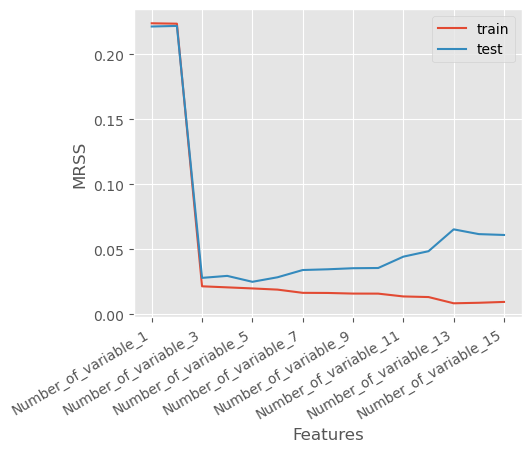

In [18]:
coef_matrix_simple[['mrss_train', 'mrss_test']].plot()
ax = plt.gca()
plt.xlabel('Features')
plt.ylabel('MRSS')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.legend(['train', 'test']);

### Overfitting Indicated by Training and Test MRSS Trends  

As observed in the plot:  
- The **Training Mean Residual Sum of Squares (MRSS)** consistently decreases as the number of features increases.  
- However, after a certain point, the **Test MRSS starts to rise**, indicating that the model is no longer generalizing well to unseen data.  

This trend suggests that while adding more features helps the model fit the **training data** better, it also causes the model to **memorize noise**, leading to poor performance on the test set.  

This is a classic sign of **overfitting**, where the model captures excessive complexity in the data rather than the true underlying pattern.

Next, let's mitigate the overfitting issue using regularization

## Regularization: Combating Overfitting

Regularization is a technique that **modifies the loss function** by adding a penalty term to control model complexity.  
This helps **prevent overfitting** by discouraging large coefficients in the model.  

### Regularized Loss Function  

The regularized loss function is given by:  

$L_{reg}(\beta) = L(\beta) + \alpha R(\beta)$


where:
- $L(\beta)$ is the original loss function (e.g., Mean Squared Error in linear regression).  
- $R(\beta)$ is the **regularization term**, which penalizes large coefficients.  
- $\alpha$ is a **hyperparameter** that controls the strength of regularization.  

### Regularization Does Not Penalize the Intercept 

- The **intercept (bias term)** captures the **baseline mean** of the target variable.  
- Penalizing the intercept would **shift predictions** incorrectly instead of controlling complexity.  
- Thus, regularization **only applies to feature coefficients**, not the intercept.
  

### Types of Regularization

1. **L1 Regularization (Lasso Regression)**: Encourages sparsity by driving some coefficients to zero.  
2. **L2 Regularization (Ridge Regression)**: Shrinks coefficients but keeps all of them nonzero.  
3. **Elastic Net**: A combination of both L1 and L2 regularization.  

By applying **regularization**, we obtain models that balance **bias-variance tradeoff**, leading to **better generalization**.

###  Why Is Feature Scaling Required in Regularization?

#### The Effect of Feature Magnitudes on Regularization
Regularization techniques such as **Lasso (L1)**, **Ridge (L2)**, and **Elastic Net** apply penalties to the model’s coefficients. However, when features have vastly different scales, **regularization disproportionately affects certain features**, leading to:

- **Uneven shrinkage** of coefficients, causing instability in the model.
- **Incorrect feature importance interpretation**, as some features dominate due to their larger numerical scale.
- **Suboptimal performance**, since regularization penalizes large coefficients more, even if they belong to more informative features.

####  Example: The Need for Feature Scaling
Imagine a dataset with two features:  

- **Feature 1**: Number of bedrooms (range: 1-5).  
- **Feature 2**: House area in square feet (range: 500-5000).  

Since house area has much larger values, the model assigns smaller coefficients to compensate, making regularization unfairly **biased toward smaller-scale features**.

#### How to Scale Features for Regularization
To ensure fair treatment of all features, apply **feature scaling** before training a regularized model:

##### Standardization (Recommended)
$$
x_{\text{scaled}} = \frac{x - \mu}{\sigma}
$$
- Centers the data around **zero** with unit variance.
- Used in **Lasso, Ridge, and Elastic Net**.

##### Min-Max Scaling
$$
x_{\text{scaled}} = \frac{x - x_{\min}}{x_{\max} - x_{\min}}
$$
- Scales features to a fixed **[0, 1]** range.
- Common for **neural networks** but less effective for regularization.

Let's use `StandardScaler` to scale the features

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Feature scaling on X_train
X_train_std = scaler.fit_transform(X_train)
columns = data.drop('y', axis=1).columns
X_train_std = pd.DataFrame(X_train_std, columns = columns)
X_train_std.head()
# Feature scaling on X_test
X_test_std = scaler.transform(X_test)
X_test_std = pd.DataFrame(X_test_std, columns = columns)
X_test_std.head()

,x,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15
0,-0.96,-1,-0.89,-0.78,-0.69,-0.62,-0.57,-0.52,-0.48,-0.45,-0.43,-0.4,-0.38,-0.37,-0.35
1,-0.061,-0.34,-0.49,-0.55,-0.57,-0.56,-0.53,-0.5,-0.47,-0.45,-0.42,-0.4,-0.38,-0.37,-0.35
2,-1.8,-1.2,-0.95,-0.8,-0.7,-0.62,-0.57,-0.52,-0.48,-0.45,-0.43,-0.4,-0.38,-0.37,-0.35
3,0.21,-0.051,-0.24,-0.36,-0.43,-0.46,-0.47,-0.46,-0.45,-0.43,-0.41,-0.4,-0.38,-0.36,-0.35
4,-1.7,-1.2,-0.95,-0.8,-0.7,-0.62,-0.57,-0.52,-0.48,-0.45,-0.43,-0.4,-0.38,-0.37,-0.35


In the next section, we will explore **different types of regularization techniques** and see how they help in preventing overfitting.

###  Ridge Regression: L2 Regularization


Ridge regression is a type of **linear regression** that incorporates **L2 regularization** to prevent overfitting by **penalizing large coefficients**.  

#### Ridge Regression Loss Function
The regularized loss function for Ridge regression is given by:  

$$
L_{\text{Ridge}}(\beta) = \frac{1}{n} \sum_{i=1}^{n} |y_i - \beta^\top x_i|^2 + \alpha \sum_{j=1}^{J} \beta_j^2
$$

where:  

- $y_i \text{ is the true target value for observation } i.$
- $x_i \text{ is the feature vector for observation } i.$
- $\beta \text{ is the vector of model coefficients.}$
- $\alpha \text{ is the regularization parameter, which controls the penalty strength.}$
- $\sum_{j=1}^{J} \beta_j^2 \text{ is the L2 norm (sum of squared coefficients).}$

**Note that $j$ starts from 1, excluding the intercept from regularization.**

The penalty term in Ridge regression,

$$
\sum_{j=1}^{J} \beta_j^2 = ||\beta||_2^2
$$

is the **squared L2 norm** of the coefficient vector $\beta$.  
Minimizing this norm ensures that the model coefficients remain **small and stable**, reducing sensitivity to variations in the data.

Let's build a Ridge Regression model using scikit-learn,  The `alpha` parameter controls the strength of the regularization:

In [20]:
from sklearn.linear_model import Ridge
# defining a function which will fit ridge regression model, plot the results, and return the coefficients
def ridge_regression(train_x, train_y, test_x, test_y, alpha, models_to_plot={}):
    
    #fit the model
    ridgereg = Ridge(alpha=alpha)
    ridgereg.fit(train_x, train_y)
    train_y_pred = ridgereg.predict(train_x)
    test_y_pred = ridgereg.predict(test_x)
    
    #check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        # plt_tight_layout()
        plt.plot(*sort_xy(train_x.values[:, 0], train_y_pred))
        plt.plot(train_x.values[:, 0], train_y, '.')
        
        plt.title('Plot for alpha: %.3g'%alpha)
        
    #return the result in pre-defined format
    mrss_train = sum((train_y_pred - train_y)**2)/train_x.shape[0]
    ret = [mrss_train]
    
    mrss_test = sum((test_y_pred - test_y)**2)/test_x.shape[0]
    ret.extend([mrss_test])
    
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    
    return ret

Let's experiment with different values of alpha in Ridge Regression and observe how it affects the model's coefficients and performance. 

In [21]:
#initialize a dataframe to store the coefficient:
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]
col = ['mrss_train', 'mrss_test', 'intercept'] + ['coef_VaR_%d'%i for i in range(1, 16)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0, 10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

In [22]:
# Define the number of features for which a plot is required:
models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 5:236}

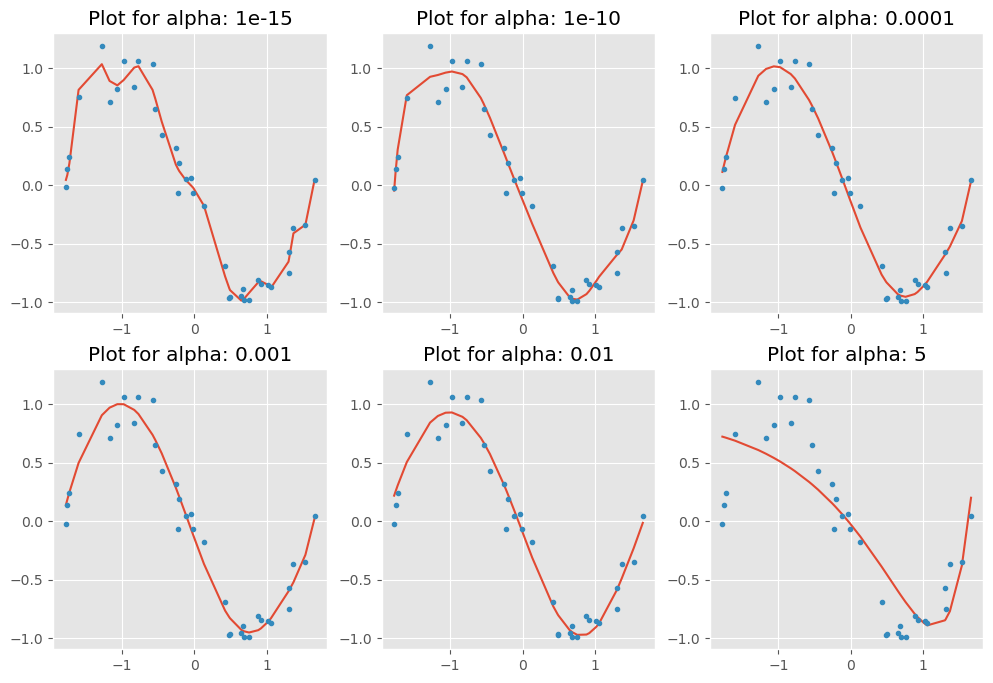

In [23]:
#Iterate over the 10 alpha values:
plt.figure(figsize=(12, 8))
for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(X_train_std, train_y, X_test_std, test_y, alpha_ridge[i], models_to_plot)

As we can observe, when increasing alpha, the model becomes simpler, with coefficients shrinking more aggressively due to stronger regularization. This reduces the risk of overfitting but may lead to underfitting if alpha is set too high.

Next, let's output the training error versus the test error and examine how the feature coefficients change with different alpha values.

In [24]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_ridge

,mrss_train,mrss_test,intercept,coef_VaR_1,coef_VaR_2,coef_VaR_3,coef_VaR_4,coef_VaR_5,coef_VaR_6,coef_VaR_7,coef_VaR_8,coef_VaR_9,coef_VaR_10,coef_VaR_11,coef_VaR_12,coef_VaR_13,coef_VaR_14,coef_VaR_15
alpha_1e-15,0.0092,0.059,-0.072,-2.8,1.9e+02,-1.3e+03,-6e+03,1.1e+05,-5.6e+05,1.5e+06,-2e+06,7.5e+05,1.4e+06,-1.4e+06,-7.5e+05,2e+06,-1.3e+06,2.8e+05
alpha_1e-10,0.016,0.036,-0.072,12,-1.3e+02,7.1e+02,-1.8e+03,1.8e+03,1.1e+03,-2.8e+03,-7.9e+02,2.4e+03,1.5e+03,-1.4e+03,-2.1e+03,3.5e+02,2.2e+03,-1e+03
alpha_1e-08,0.017,0.034,-0.072,8.1,-70,2.8e+02,-5.6e+02,4.2e+02,1.7e+02,-2.6e+02,-1.8e+02,1e+02,1.8e+02,34,-1.1e+02,-79,64,3.8
alpha_0.0001,0.019,0.024,-0.072,2.9,-8.2,4.5,-0.022,-1.3,0.31,1.8,2.1,1.1,-0.44,-1.8,-2.4,-1.9,-0.06,3.1
alpha_0.001,0.019,0.023,-0.072,2.5,-5.6,-0.5,1.3,1.6,1.4,0.84,0.21,-0.39,-0.82,-1,-0.91,-0.48,0.28,1.3
alpha_0.01,0.022,0.024,-0.072,1.9,-4,-1.3,0.73,1.5,1.3,0.82,0.23,-0.26,-0.58,-0.69,-0.6,-0.31,0.13,0.72
alpha_1,0.089,0.093,-0.072,0.08,-0.61,-0.48,-0.22,-0.011,0.13,0.2,0.22,0.21,0.17,0.12,0.058,-0.0066,-0.072,-0.14
alpha_5,0.12,0.13,-0.072,-0.17,-0.3,-0.24,-0.14,-0.055,0.0059,0.046,0.069,0.08,0.081,0.077,0.069,0.057,0.045,0.031
alpha_10,0.14,0.14,-0.072,-0.19,-0.24,-0.18,-0.12,-0.058,-0.014,0.018,0.039,0.053,0.06,0.063,0.064,0.062,0.059,0.054
alpha_20,0.16,0.17,-0.072,-0.18,-0.19,-0.15,-0.097,-0.055,-0.022,0.0025,0.021,0.034,0.043,0.049,0.053,0.056,0.057,0.057


To better observe the pattern, let's visualize how the coefficients change as we increase $\alpha$


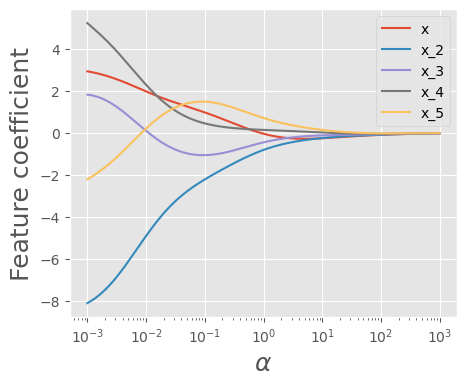

In [25]:
def plot_ridge_reg_coeff(train_x):
    alphas = np.logspace(3,-3,200)
    coefs = []
    #X_train_std, train_y
    for a in alphas:        
        ridge = Ridge(alpha = a)
        ridge.fit(train_x, train_y)
        coefs.append(ridge.coef_)
    #Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
    plt.xlabel('xlabel', fontsize=18)
    plt.ylabel('ylabel', fontsize=18)
    plt.plot(alphas, coefs)
    plt.xscale('log')
    plt.xlabel(r'$\alpha$')
    plt.ylabel('Feature coefficient')
    plt.legend(train_x.columns );    
plot_ridge_reg_coeff(X_train_std.iloc[:,:5])
plt.savefig("test.png")

As we can see, as $\alpha$ increases, the coefficients become smaller and approach zero. Now, let's examine the number of zero coefficients.

In [26]:
coef_matrix_ridge.apply(lambda x: sum(x.values==0),axis=1)

alpha_1e-15     0
alpha_1e-10     0
alpha_1e-08     0
alpha_0.0001    0
alpha_0.001     0
alpha_0.01      0
alpha_1         0
alpha_5         0
alpha_10        0
alpha_20        0
dtype: int32

Let's plot how the test error and training error change as we increase $\alpha$

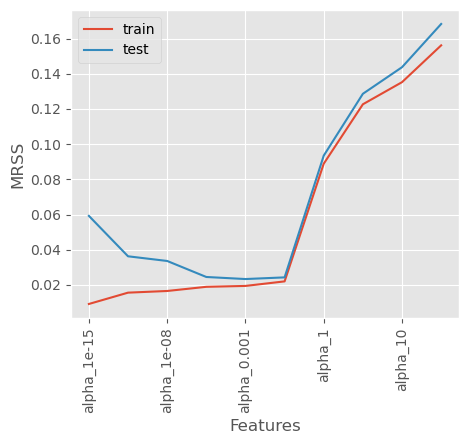

In [27]:
coef_matrix_ridge[['mrss_train', 'mrss_test']].plot()
plt.xlabel('Features')
plt.ylabel('MRSS')
plt.xticks(rotation=90)
plt.legend(['train', 'test']);

As we can observe, as $𝜆$ increases beyond a certain value, both the training MRSS and test MRSS begin to rise, indicating that the model starts underfitting.

### Lasso Regression: L1 Regularization


LASSO stands for **Least Absolute Shrinkage and Selection Operator**. There are two key aspects in this name:  
- **"Absolute"** refers to the use of the absolute values of the coefficients in the penalty term.  
- **"Selection"** highlights LASSO’s ability to shrink some coefficients to exactly zero, effectively performing **feature selection**.  

Lasso regression performs **L1 regularization**, which helps prevent overfitting by penalizing large coefficients and enforcing sparsity in the model.

#### Lasso Regression Loss Function 
In standard **linear regression**, the loss function is the **Mean Squared Error (MSE)**:  


$$L_{\text{MSE}}(\beta) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \beta^\top x_i)^2$$
 

LASSO modifies this by adding an **L1 regularization** penalty, leading to the following **regularized loss function**:  


$$L_{\text{Lasso}}(\beta) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \beta^\top x_i)^2 + \alpha  \sum_{j=1}^{J} |\beta_j|$$


where:  

- $y_i \text{ is the true target value for observation } i.$
- $x_i \text{ is the feature vector for observation } i.$
- $\beta \text{ is the vector of model coefficients.}$
- $\alpha \text{ is the regularization parameter, which controls the penalty strength.}$
- $\sum_{j=1}^{J} |\beta_j| \text{ is the } \mathbf{L_1} \text{ norm (sum of absolute values of coefficients).}$


The penalty term in Lasso regression,  

$$
\sum_{j=1}^{J} |\beta_j| = ||\beta||_1
$$

is the **L1 norm** of the coefficient vector ( $\beta$ ).  
Minimizing this norm encourages **sparsity**, meaning some coefficients become exactly zero, leading to an automatically selected subset of features.

Next, let's build a Lasso Regression model. Similar to Ridge regression, we will explore a range of values for the regularization parameter alpha.

In [28]:
from sklearn.linear_model import Lasso
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 0.1, 1, 5]

In [51]:
# Defining a function which will fit lasso regression model, plot the results, and return the coefficient
def lasso_regression(train_x, train_y, test_x, test_y, alpha, models_to_plot={}):
    
    #fit the model
    if alpha == 0:
        lassoreg = LinearRegression()    
    else:
        lassoreg = Lasso(alpha=alpha, max_iter=200000000, tol=0.01)
    lassoreg.fit(train_x, train_y)
    train_y_pred = lassoreg.predict(train_x)
    test_y_pred = lassoreg.predict(test_x)
        
        
    
    #check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        # plt_tight_layout()
        plt.plot(*sort_xy(train_x.values[:, 0], train_y_pred))
        plt.plot(train_x.values[:, 0:1], train_y, '.')
        
        plt.title('Plot for alpha: %.3g'%alpha)
        
    #return the result in pre-defined format
    mrss_train = sum((train_y_pred - train_y)**2)/train_x.shape[0]
    ret = [mrss_train]
    
    mrss_test = sum((test_y_pred - test_y)**2)/test_x.shape[0]
    ret.extend([mrss_test])
    
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    
    return ret

In [52]:
#initialize a dataframe to store the coefficient:
col = ['mrss_train', 'mrss_test', 'intercept'] + ['coef_VaR_%d'%i for i in range(1, 16)]
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(0, 10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

In [53]:
# Define the number of features for which a plot is required:
models_to_plot = {1e-10:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 0.1:236}

In [54]:
models_to_plot

{1e-10: 231, 1e-05: 232, 0.0001: 233, 0.001: 234, 0.01: 235, 0.1: 236}

In [ ]:
#Iterate over the 10 alpha values:
plt.figure(figsize=(12, 8))
for i in range(10):
    coef_matrix_lasso.iloc[i,] = lasso_regression(X_train_std, train_y, X_test_std, test_y, alpha_lasso[i], models_to_plot)

In [52]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_lasso

,mrss_train,mrss_test,intercept,coef_VaR_1,coef_VaR_2,coef_VaR_3,coef_VaR_4,coef_VaR_5,coef_VaR_6,coef_VaR_7,coef_VaR_8,coef_VaR_9,coef_VaR_10,coef_VaR_11,coef_VaR_12,coef_VaR_13,coef_VaR_14,coef_VaR_15
alpha_1e-15,0.019,0.024,-0.072,2.8,-6.9,0.83,1.5,1.6,1,0.34,-0.23,-0.57,-0.66,-0.57,-0.35,-0.058,0.27,0.6
alpha_1e-10,0.019,0.024,-0.072,2.8,-6.9,0.83,1.5,1.6,1,0.34,-0.23,-0.57,-0.66,-0.57,-0.35,-0.058,0.27,0.6
alpha_1e-08,0.019,0.024,-0.072,2.8,-6.9,0.83,1.5,1.6,1,0.34,-0.23,-0.57,-0.66,-0.57,-0.35,-0.058,0.27,0.6
alpha_1e-05,0.019,0.024,-0.072,2.8,-6.8,0.73,1.7,1.6,0.93,0.21,0,-0.6,-0.68,-0.55,-0.3,-0,0.023,0.71
alpha_0.0001,0.02,0.024,-0.072,2.7,-6.5,0,2.8,1.4,0,0,-0,-0,-0.68,-0.43,-0,-0,0,0.35
alpha_0.001,0.024,0.026,-0.072,2,-4.5,-0,0,2.6,0,0,0,-0,-0,-0,-0,-0.37,-0,-0
alpha_0.01,0.084,0.088,-0.072,0.27,-1.3,-0,-0,0,0,0,0.68,0,0,0,0,0,0,-0
alpha_0.1,0.19,0.2,-0.072,-0.22,-0.27,-0,-0,-0,0,0,0,0,0,0,0,0,0,0.12
alpha_1,0.49,0.53,-0.072,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_5,0.49,0.53,-0.072,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0


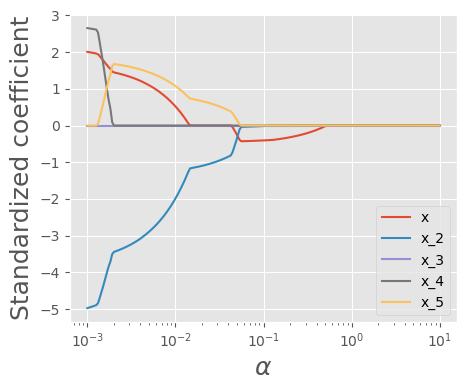

In [53]:
def plot_lasso_reg_coeff(train_x):
    alphas = np.logspace(1,-3,200)
    coefs = []
    #X_train_std, train_y
    for a in alphas:        
        laso = Lasso(alpha=a, max_iter = 100000)
        laso.fit(train_x, train_y)
        coefs.append(laso.coef_)
    #Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
    plt.xlabel('xlabel', fontsize=18)
    plt.ylabel('ylabel', fontsize=18)
    plt.plot(alphas, coefs)
    plt.xscale('log')
    plt.xlabel(r'$\alpha$')
    plt.ylabel('Standardized coefficient')
    plt.legend(train_x.columns );    
plot_lasso_reg_coeff(X_train_std.iloc[:,:5])
plt.savefig("test1.png")

In [54]:
coef_matrix_lasso.apply(lambda x: sum(x.values==0),axis=1)

alpha_1e-15      0
alpha_1e-10      0
alpha_1e-08      0
alpha_1e-05      2
alpha_0.0001     8
alpha_0.001     11
alpha_0.01      12
alpha_0.1       12
alpha_1         15
alpha_5         15
dtype: int32

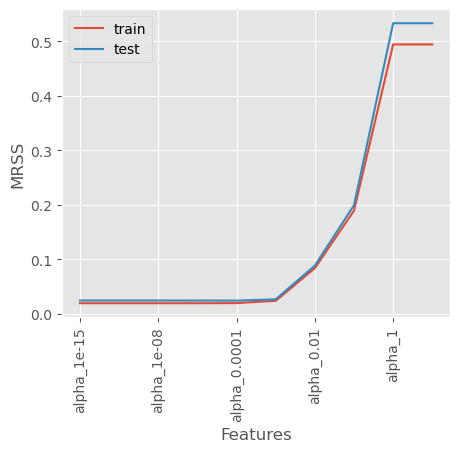

In [55]:
coef_matrix_lasso[['mrss_train', 'mrss_test']].plot()
plt.xlabel('Features')
plt.ylabel('MRSS')
plt.xticks(rotation=90)
plt.legend(['train', 'test'])

**Effect of alpha in Lasso Regression**
- **Small alpha (close to 0):** The penalty is minimal, and Lasso behaves like ordinary linear regression.
- **Moderate alpha:** Some coefficients shrink, and some become exactly zero, performing feature selection.
- **Large alpha:** Many coefficients become zero, leading to a very simple model (potentially underfitting).

### Elastic Net Regression: Combining L1 and L2 Regularization

#### Mathematical Formulation* 
Elastic Net regression combines both **L1 (Lasso) and L2 (Ridge) penalties**, balancing feature selection and coefficient shrinkage. The **regularized loss function** for Elastic Net is given by:

$$ 
L_{\text{ElasticNet}}(\beta) = \frac{1}{2n} \sum_{i=1}^{n} (y_i - \beta^\top x_i)^2 + \alpha \left( (1 - \rho) \frac{1}{2} \sum_{j=1}^{p} \beta_j^2 + \rho \sum_{j=1}^{p} |\beta_j| \right)
$$

where:

- $y_i$ is the true target value for observation $i$.
- $x_i$ is the feature vector for observation $i$.
- $\beta$ is the vector of model coefficients.
- $\alpha$ is the **regularization strength** parameter in scikit-learn.
- $\rho$ is the **l1_ratio** parameter in scikit-learn, controlling the mix of L1 and L2 penalties.
- $\sum_{j=1}^{p} |\beta_j|$ is the **L1 norm**, enforcing sparsity.
- $\sum_{j=1}^{p} \beta_j^2$ is the **L2 norm**, ensuring coefficient stability.

#### Elastic Net Special Cases
- When **l1_ratio = 0**, Elastic Net behaves like **Ridge Regression (L2 regularization)**.
- When **l1_ratio = 1**, Elastic Net behaves like **Lasso Regression (L1 regularization)**.
- When **0 < l1_ratio < 1**, Elastic Net **balances feature selection (L1) and coefficient shrinkage (L2)**.

Now, let's implement an **Elastic Net Regression model** using `scikit-learn` and explore how different values of `alpha` and `l1_ratio` affect the model.


In [56]:
from sklearn.linear_model import ElasticNet
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 0.1, 1, 5]
l1_ratio=0.5

In [57]:
# Defining a function which will fit lasso regression model, plot the results, and return the coefficient
def elasticnet_regression(train_x, train_y, test_x, test_y, alpha, models_to_plot={}):
    
    #fit the model
    if alpha == 0:
        model = LinearRegression()    
    else:
        model = ElasticNet(alpha=alpha, max_iter=20000, l1_ratio=l1_ratio)
    model.fit(train_x, train_y)
    train_y_pred = model.predict(train_x)
    test_y_pred = model.predict(test_x)
        
        
    
    #check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        # plt_tight_layout()
        plt.plot(*sort_xy(train_x.values[:, 0], train_y_pred))
        plt.plot(train_x.values[:, 0:1], train_y, '.')
        
        plt.title('Plot for alpha: %.3g'%alpha)
        
    #return the result in pre-defined format
    mrss_train = sum((train_y_pred - train_y)**2)/train_x.shape[0]
    ret = [mrss_train]
    
    mrss_test = sum((test_y_pred - test_y)**2)/test_x.shape[0]
    ret.extend([mrss_test])
    
    ret.extend([model.intercept_])
    ret.extend(model.coef_)
    
    return ret

In [58]:
#initialize a dataframe to store the coefficient:
col = ['mrss_train', 'mrss_test', 'intercept'] + ['coef_VaR_%d'%i for i in range(1, 16)]
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(0, 10)]
coef_matrix_elasticnet = pd.DataFrame(index=ind, columns=col)

In [59]:
# Define the number of features for which a plot is required:
models_to_plot = {1e-10:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 0.1:236}

In [60]:
models_to_plot

{1e-10: 231, 1e-05: 232, 0.0001: 233, 0.001: 234, 0.01: 235, 0.1: 236}

c:\Users\lsi8012\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.489e-01, tolerance: 1.779e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\lsi8012\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.489e-01, tolerance: 1.779e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\lsi8012\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

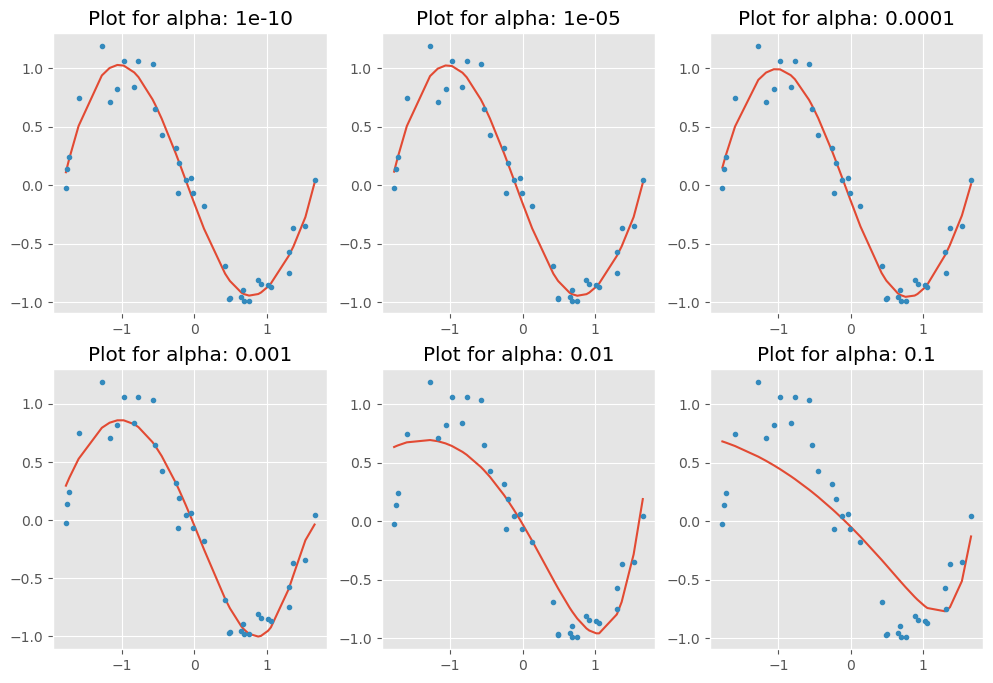

In [61]:
#Iterate over the 10 alpha values:
plt.figure(figsize=(12, 8))
for i in range(10):
    coef_matrix_elasticnet.iloc[i,] = elasticnet_regression(X_train_std, train_y, X_test_std, test_y, alpha_lasso[i], models_to_plot)

In [62]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_elasticnet

,mrss_train,mrss_test,intercept,coef_VaR_1,coef_VaR_2,coef_VaR_3,coef_VaR_4,coef_VaR_5,coef_VaR_6,coef_VaR_7,coef_VaR_8,coef_VaR_9,coef_VaR_10,coef_VaR_11,coef_VaR_12,coef_VaR_13,coef_VaR_14,coef_VaR_15
alpha_1e-15,0.019,0.024,-0.072,2.8,-6.9,0.83,1.5,1.6,1,0.34,-0.23,-0.57,-0.66,-0.57,-0.35,-0.058,0.27,0.6
alpha_1e-10,0.019,0.024,-0.072,2.8,-6.9,0.83,1.5,1.6,1,0.34,-0.23,-0.57,-0.66,-0.57,-0.35,-0.058,0.27,0.6
alpha_1e-08,0.019,0.024,-0.072,2.8,-6.9,0.83,1.5,1.6,1,0.34,-0.23,-0.57,-0.66,-0.57,-0.35,-0.058,0.27,0.6
alpha_1e-05,0.019,0.024,-0.072,2.7,-6.6,0.37,1.7,1.7,1,0.27,-0.13,-0.61,-0.69,-0.57,-0.33,-0.019,0.15,0.66
alpha_0.0001,0.02,0.023,-0.072,2.4,-5.5,-0.6,1.3,2.2,1.2,0.056,-0,-0.36,-0.83,-0.68,-0.26,-0,0,0.71
alpha_0.001,0.028,0.03,-0.072,1.6,-3.3,-0.6,0,0.99,1.1,0.54,0,0,-0,-0,-0.21,-0.25,-0.11,-0
alpha_0.01,0.076,0.081,-0.072,0.31,-1.1,-0.48,-0,0,0.14,0.35,0.33,0.14,0,0,0,-0,-0,-0.067
alpha_0.1,0.15,0.16,-0.072,-0.19,-0.41,-0.0068,-0,-0,0,0,0,0,0,0,0.04,0.062,0.073,0.075
alpha_1,0.48,0.52,-0.072,-0.013,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_5,0.49,0.53,-0.072,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0


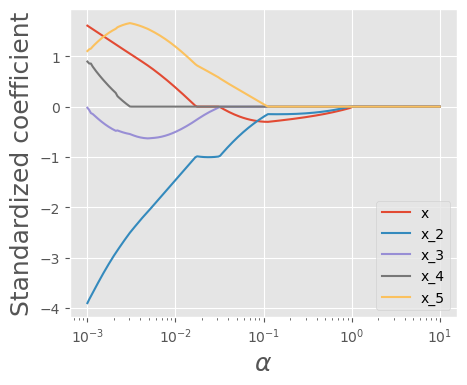

In [63]:
def plot_elasticnet_reg_coeff(train_x):
    alphas = np.logspace(1,-3,200)
    coefs = []
    #X_train_std, train_y
    for a in alphas:        
        model = ElasticNet(alpha=a, max_iter=20000, l1_ratio=l1_ratio)
        model.fit(train_x, train_y)
        coefs.append(model.coef_)
    #Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
    plt.xlabel('xlabel', fontsize=18)
    plt.ylabel('ylabel', fontsize=18)
    plt.plot(alphas, coefs)
    plt.xscale('log')
    plt.xlabel(r'$\alpha$')
    plt.ylabel('Standardized coefficient')
    plt.legend(train_x.columns );    
plot_elasticnet_reg_coeff(X_train_std.iloc[:,:5])
plt.savefig("test2.png")

In [64]:
coef_matrix_elasticnet.apply(lambda x: sum(x.values==0),axis=1)

alpha_1e-15      0
alpha_1e-10      0
alpha_1e-08      0
alpha_1e-05      0
alpha_0.0001     3
alpha_0.001      6
alpha_0.01       7
alpha_0.1        8
alpha_1         14
alpha_5         15
dtype: int32

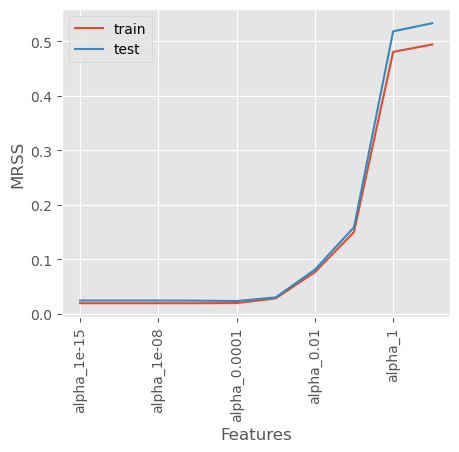

In [65]:
coef_matrix_elasticnet[['mrss_train', 'mrss_test']].plot()
plt.xlabel('Features')
plt.ylabel('MRSS')
plt.xticks(rotation=90)
plt.legend(['train', 'test']);

ElasticNet is controlled by these key parameters:

- **alpha** (`float`, default=`1.0`):  
  The regularization strength multiplier. Higher values increase regularization.
  
- **l1_ratio** (`float`, default=`0.5`):  
  The mixing parameter between L1 and L2 penalties:
  - `l1_ratio = 0`: Pure Ridge regression  
  - `l1_ratio = 1`: Pure Lasso regression  
  - `0 < l1_ratio < 1`: ElasticNet with mixed penalties  

### `RidgeCV`, `LassoCV`, and `ElasticNetCV` in Scikit-Learn

In Scikit-Learn, `RidgeCV`, `LassoCV`, and `ElasticNetCV` are cross-validation (CV) versions of **Ridge**, **Lasso**, and **Elastic Net** regression models, respectively. These versions **automatically select the best regularization strength** (`alpha`) by performing internal cross-validation.


#### Overview of RidgeCV, LassoCV, and ElasticNetCV**

| Model         | Regularization Type          | Purpose                                                                 | How Alpha is Chosen? |
|--------------|-----------------------------|-------------------------------------------------------------------------|----------------------|
| **RidgeCV**  | L2 (Ridge)                   | Shrinks coefficients to handle overfitting, but keeps all features. | Uses cross-validation to select the best `alpha`. |
| **LassoCV**  | L1 (Lasso)                   | Shrinks coefficients, but also **removes** some features by setting coefficients to zero. | Uses cross-validation to find the best `alpha`. |
| **ElasticNetCV** | L1 + L2 (Elastic Net)    | Balances Ridge and Lasso. | Uses cross-validation to find the best `alpha` and `l1_ratio`. |


#### How to Use `RidgeCV`, `LassoCV`, and` ElasticNetCV`

Each model automatically selects the optimal `alpha` value through internal cross-validation without using a loop through the `alpha` values

## Reference

https://www.linkedin.com/pulse/tutorial-ridge-lasso-regression-subhajit-mondal/?trk=read_related_article-card_title